In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from shapely.geometry import Point

%matplotlib inline

pd.options.mode.chained_assignment = None


In [2]:
#to do:

input_folder = "/Users/kazv/VanBovenDrive/VanBoven MT/500 Projects/P2 Wiertsema/data/Sonderingen/Sonderingen MOS/"
file_list = os.listdir(input_folder)
valid_files = [x for x in file_list if x.endswith('.gef')]


In [5]:
GEF = os.path.join(input_folder, valid_files[3])
with open(GEF, 'r', encoding='utf-8',errors='ignore') as fdata:
        contents = fdata.readlines()
    
#Get info from GEF file metadata
columnsep = [s for s in contents if "#COLUMNSEPARATOR" in s][0].split(' ')[1][0]
XYID = [s for s in contents if "#XYID" in s][0].split(' ')
x = float(XYID[2][:-1])
y = float(XYID[3][:-1])

EOH_line = [s for s in contents if "#EOH=" in s] #Last line before data starts
start_line = contents.index(EOH_line[0])+1#line where data starts


In [11]:
contents


4.2

In [120]:
def gdf_from_gef(GEF):
    #Read lines
    with open(GEF, 'r', encoding='utf-8',errors='ignore') as fdata:
        contents = fdata.readlines()
    
    #Get info from GEF file metadata
    columnsep = [s for s in contents if "#COLUMNSEPARATOR" in s][0].split(' ')[1][0]
    XYID = [s for s in contents if "#XYID" in s][0].split(' ')
    ZID = [s for s in contents if "#ZID" in s][0].split(' ')
    x = float(XYID[2][:-1])
    y = float(XYID[3][:-1])
    AHN_height = float(ZID[2][:-1])
    
    test_ID = [s for s in contents if "#TESTID" in s][0].split('=')[1][1:-1]
    EOH_line = [s for s in contents if "#EOH=" in s] #Last line before data starts
    start_line = contents.index(EOH_line[0])+1#line where data starts

    #Create dataframe from GEF file
    
    df = pd.DataFrame(x.split(columnsep) for x in contents[start_line::])
    #Drop last column, which only holds line seperators
    df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
    
    
    #Set column names
    col_info = [s for s in contents if "#COLUMNINFO= " in s]
    col_void_info = [s for s in contents if "COLUMNVOID= " in s]
    col_void = float(col_void_info[0].split(',')[1])#assuming column voids are always constant
    
    cols = []
    for info in col_info:
        info_split = info.split(',')
        unit = info_split[1].strip()
        quantity = info_split[2].strip()
        col_name = quantity+' [{}]'.format(unit)
        cols.append(col_name)
    
    df.columns = cols
    
    #Make all values numeric, instead of strings
    df = df[cols].apply(pd.to_numeric, errors='coerce')
    
    #Add test_ID column (can be used later for grouping purposes on measurement location)
    df['TESTID'] = test_ID
    
    #Add thickness based on Sondeerlengte
    df['Dikte [m]']=df['Sondeerlengte [m]'].diff(1)
    
    
    #Get AHN height of sondeersection bottom
    df['AHN'] = AHN_height - df['Gecorrigeerde diepte [m]']
    
    #Remove void values and replace by nans
    df = df.replace(col_void, float('nan'))
    
    #Convert to GeoDataFrame and add geometry
    gdf = gpd.GeoDataFrame(df)
    gdf.crs = {'init': 'epsg:28992'}
    gdf['geometry']= Point(x,y)
    
    return gdf


In [131]:
gdf = gpd.GeoDataFrame([])
for file in valid_files:
    GEF = os.path.join(input_folder, file)
    gdf_new = gdf_from_gef(GEF)
    gdf = gdf.append(gdf_new, sort=False)
#gdf.reset_index(inplace=True) <-- dit levert gedoe op

    


In [147]:
gdf.head()

,Sondeerlengte [m],Conusweerstand [MPa],Gecorrigeerde conusweerstand [MPa],Plaatselijke wrijving [MPa],Wrijvingsgetal [%],Waterspanning u2 [MPa],Helling [Graden],Elektrische geleidbaarheid [S/m],Gecorrigeerde diepte [m],TESTID,Dikte [m],AHN,geometry,Helling N-Z [Graden],Helling O-W [Graden]
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,CPTU G20.0 + 40BITE,NaN,1.64,POINT (81527.31 425532.27),NaN,NaN
1,0.01,0.095,0.095,0.006,1.274,0.001,0.288,0.010,0.01,CPTU G20.0 + 40BITE,0.01,1.63,POINT (81527.31 425532.27),NaN,NaN
2,0.03,0.176,0.176,0.004,0.601,0.004,0.953,0.010,0.03,CPTU G20.0 + 40BITE,0.02,1.61,POINT (81527.31 425532.27),NaN,NaN
3,0.05,0.586,0.586,0.008,1.039,0.001,0.282,0.006,0.05,CPTU G20.0 + 40BITE,0.02,1.59,POINT (81527.31 425532.27),NaN,NaN
4,0.07,1.047,1.047,0.008,0.856,0.001,0.663,0.006,0.07,CPTU G20.0 + 40BITE,0.02,1.57,POINT (81527.31 425532.27),NaN,NaN


In [150]:
output_file = "/Users/kazv/VanBovenDrive/VanBoven MT/500 Projects/P2 Wiertsema/data/GEF_output.shp"
output = gdf[['Sondeerlengte [m]','Gecorrigeerde conusweerstand [MPa]','Plaatselijke wrijving [MPa]','Elektrische geleidbaarheid [S/m]','Dikte [m]','AHN','geometry']]
output.to_file(driver = 'ESRI Shapefile', filename = output_file)
print('Ready!')

Ready!


In [153]:
test_output = output.dropna(axis=0)

In [157]:
test_output.to_file(driver = 'ESRI Shapefile', filename = output_file)
print('Ready!')

Ready!


In [ ]:
#gecorrigeerde conusweerstand en plaatselijke wrijvig behouden


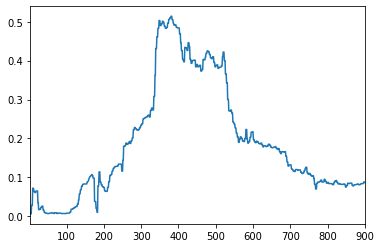

In [30]:
gdf['Elektrische geleidbaarheid [S/m]'][gdf['Elektrische geleidbaarheid [S/m]']>0].iloc[1:900].plot()

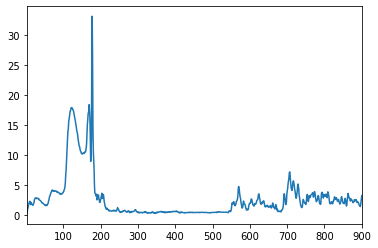

In [29]:
gdf['Gecorrigeerde conusweerstand [MPa]'][gdf['Gecorrigeerde conusweerstand [MPa]']>0].iloc[1:900].plot()

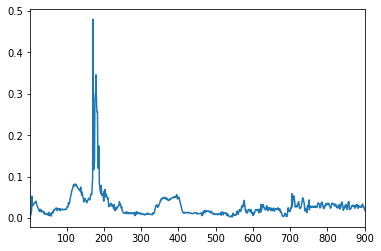

In [31]:
gdf['Plaatselijke wrijving [MPa]'][gdf['Plaatselijke wrijving [MPa]']>0].iloc[1:900].plot()

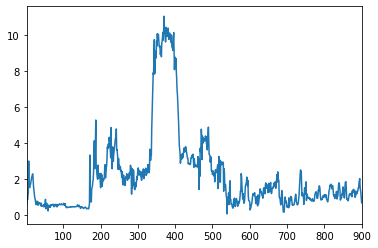

In [32]:
gdf['Wrijvingsgetal [%]'][gdf['Wrijvingsgetal [%]']>0].iloc[1:900].plot()